# SIR Example

The SIR model is an epidemiological model describing the dynamics of the number of individuals in three possible
states: susceptible S, infectious I, and recovered or deceased R.

The SIR task consists in inferring the contact rate $\beta$ and the mean recovery rate $\gamma$, given a sampled number of individuals in the infectious group I in 10 evenly-spaced points in time.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import numpy as np

import sbibm
from sbibm.algorithms import snpe
from sbibm.metrics import c2st
from sbibm.visualisation import fig_posterior
from sbi.analysis import pairplot, marginal_plot

from loss_calibration.sir import plot_observations, load_data, generate_data
from loss_calibration.npe import train_npe
from loss_calibration.utils import format_axis

## Task, Prior, Simulator

Use implementation provided by sbibm.

In [3]:
task = sbibm.get_task('sir')
prior = task.get_prior()
simulator = task.get_simulator()

In [4]:
print(task.dim_data,              # dimensionality data, here: 20
      task.dim_parameters,        # dimensionality parameters, here: 4
      task.num_observations)      # number of different observations x_o available, here: 10

10 2 10


In [5]:
task.get_true_parameters(num_observation=1)
task.get_observation(num_observation=1).shape

torch.Size([1, 10])

Take a look at the observations

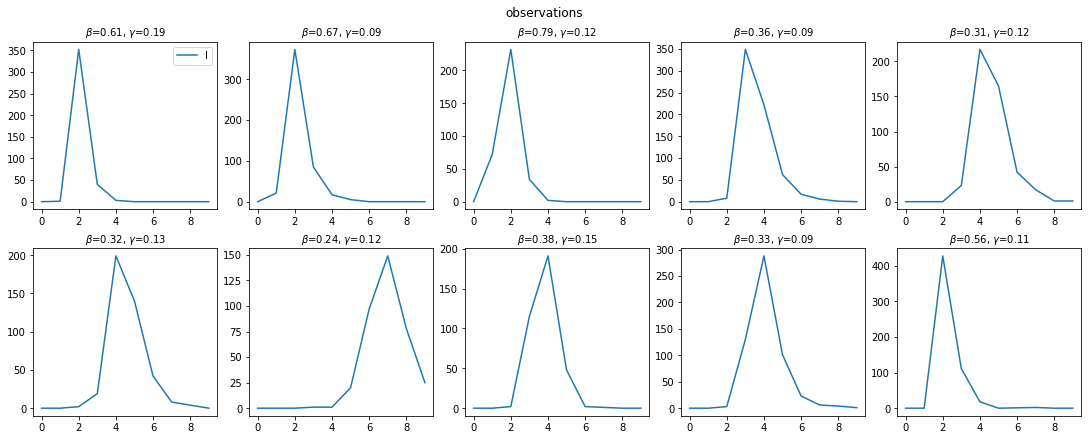

In [6]:
plot_observations()

Check out prior

In [7]:
#prior defined as Log Normal with 
mu_beta = 0.4
sigma_beta = 0.5
mu_gamma = 1/8
sigma_gamma = 0.2

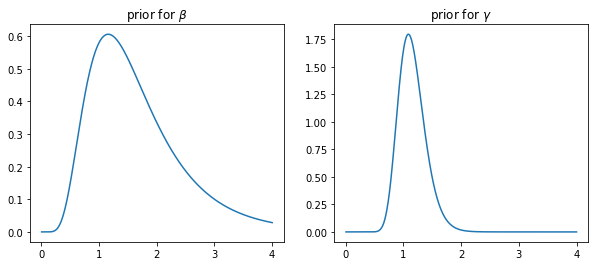

In [8]:
ths  = torch.linspace(0,4, 500)
prior_beta = torch.distributions.LogNormal(mu_beta, sigma_beta)
prior_gamma = torch.distributions.LogNormal(mu_gamma, sigma_gamma)

fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].plot(ths, torch.exp(prior_beta.log_prob(ths)))
axes[0].set_title(r'prior for $\beta$')
axes[1].plot(ths, torch.exp(prior_gamma.log_prob(ths)))
axes[1].set_title(r'prior for $\gamma$')
plt.show()

Simulator given by ODE described in SBI Benchmark paper

## True Posterior

given by reference samples for each observation

## Generate training data $(\theta, x) \sim p(\theta)p(x|\theta)$

In [9]:
load = True
if load: 
   theta_train, x_train, theta_val, x_val, theta_test, x_test = load_data()
else: 
   theta_train, x_train, theta_val, x_val, theta_test, x_test = generate_data()

Load data from './data/sir', device = cpu.


## NPE

In [11]:
reference_samples = [task.get_reference_posterior_samples(num_observation=n+1) for n in range(10)]

num_samples=5000
num_sim = 100_000

train_posterior = False
if train_posterior:  
    # since NPE is amoritzed, return the posterior and use it for all observations
    npe_posterior = train_npe(task, theta_train, x_train, num_observation=1)
    torch.save(npe_posterior, f"./results/sir/npe/npe_posterior_sim{num_sim//1000}k_unwraped.pt")
else: 
    npe_posterior = torch.load(f"./results/sir/npe/npe_posterior_sim{num_sim//1000}k_unwraped.pt")

In [12]:
num_samples = 10000
npe_samples = []
for n in range(10):
    samples = npe_posterior.sample((num_samples,), x = task.get_observation(n+1))
    npe_samples.append(samples)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

/Users/mgorecki/.virtualenvs/bm_venv/lib/python3.8/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /Users/distiller/project/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  outputs, _ = torch.triangular_solve(


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [13]:
c2st_accuracy = c2st(reference_samples[0], npe_samples[0])
c2st_accuracy

tensor([0.5796])

### Pairplots

observation 1


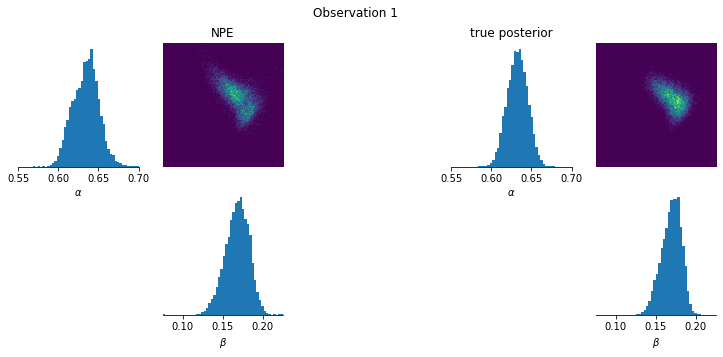

observation 2


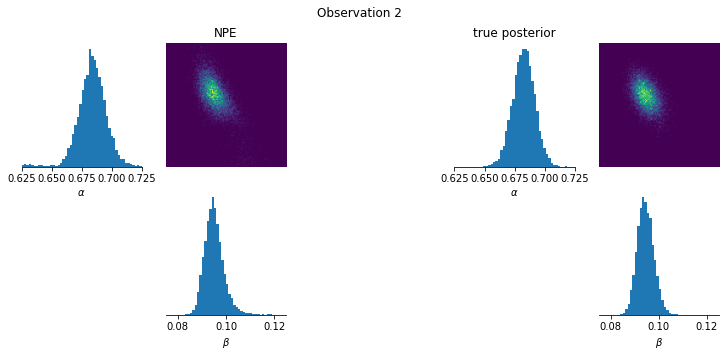

observation 3


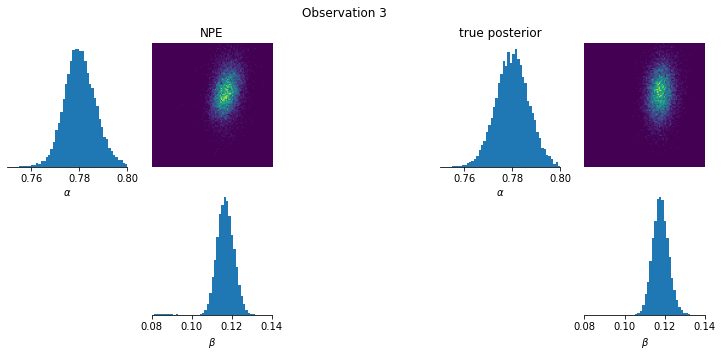

observation 4


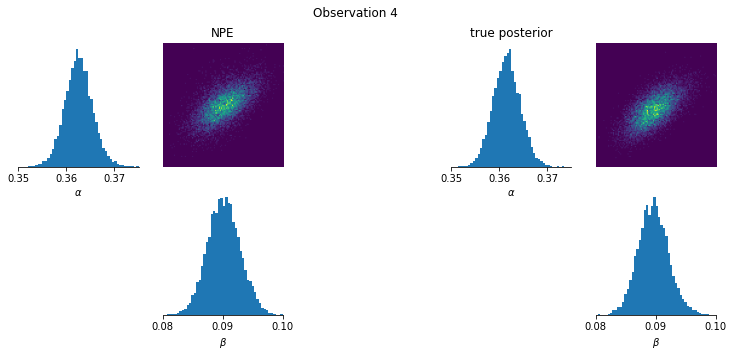

observation 5


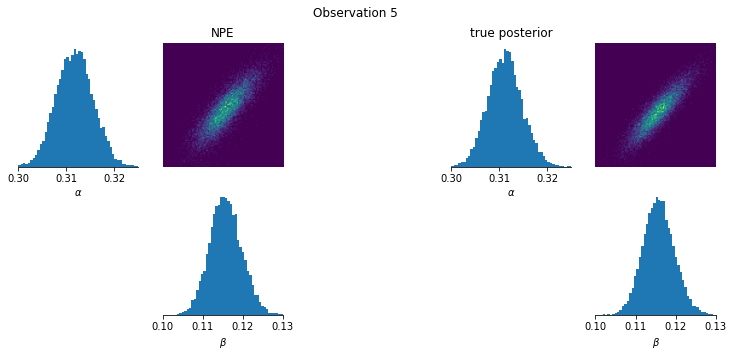

observation 6


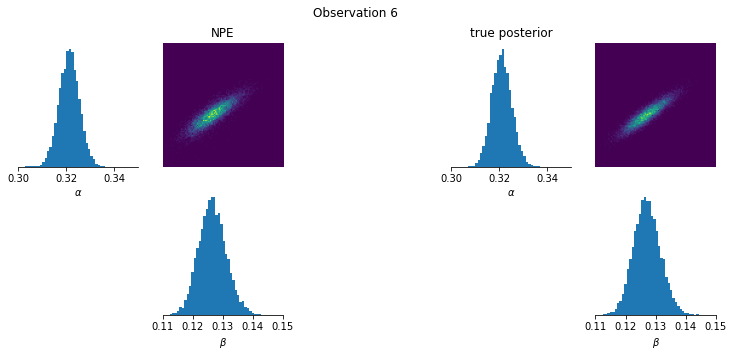

observation 7


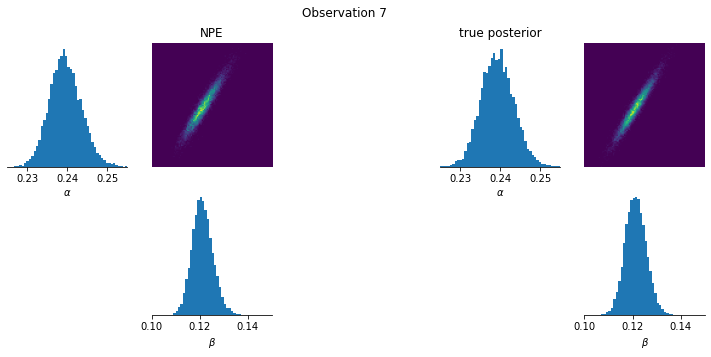

observation 8


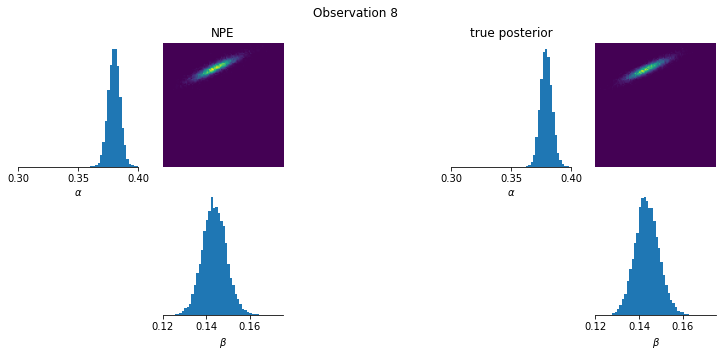

observation 9


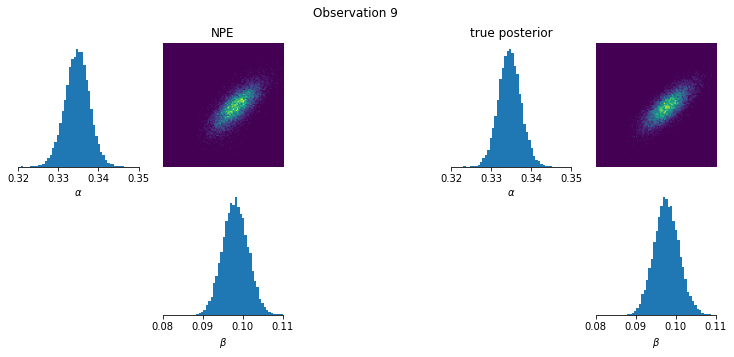

observation 10


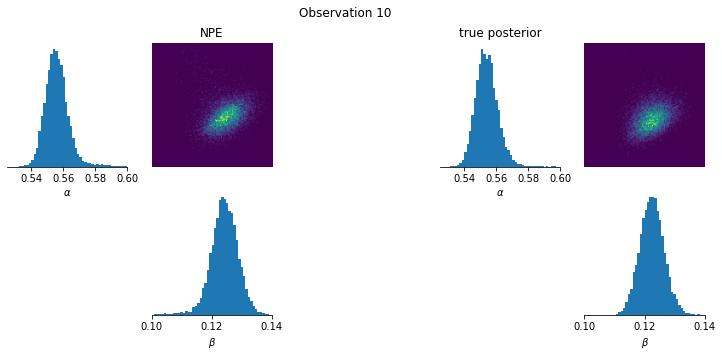

In [14]:
for obs in range(1,11):
    print('observation', obs)
    # choose limits such that all samples are included
    limits = [list(p) for p in zip(torch.min(torch.min(torch.vstack(reference_samples), dim=0).values, 
                                             torch.min(torch.vstack(npe_samples), dim=0).values).tolist(), 
                                   torch.max(torch.max(torch.vstack(reference_samples), dim=0).values, 
                                             torch.max(torch.vstack(npe_samples), dim=0).values).tolist())]
    limit_per_obs = {"1": [[0.55, 0.7], [0.075, 0.225]],
                  "2": [[0.625, 0.725], [0.075, 0.125]],
                  "3": [[0.75, 0.8], [0.08, 0.14]],
                  "4": [[0.35, 0.375], [0.08, 0.1]],
                  "5": [[0.3, 0.325], [0.1, 0.13]],
                  "6": [[0.3, 0.35], [0.11, 0.15]],
                  "7": [[0.225, 0.255], [0.1, 0.15]],
                  "8": [[0.3, 0.4], [0.12, 0.175]],
                  "9": [[0.32, 0.35], [0.08, 0.11]],
                  "10": [[0.525, 0.6], [0.1, 0.14]],}
    limits = limit_per_obs[str(obs)]
    labels=[r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$']
    dims = 2
    rows = dims
    cols = 2*dims+1
    fig, axes = plt.subplots(rows,cols,figsize=(cols*2.5,rows*2.5))#, constrained_layout = True)
    fig.suptitle(f'Observation {obs}')
    axes[0,dims//2].set_title('NPE')
    axes[0,(2*dims)//2+1].set_title('true posterior')
    for r in range(rows):
        for c in range(cols):
            # diagonals
            if r==c: 
                format_axis(axes[r,c], xhide=False, xlabel=labels[c], yhide=True,)
                format_axis(axes[r,c+dims+1], xhide=False, xlabel=labels[c], yhide=True,)
                axes[r,c].hist(npe_samples[obs-1][:,c%dims], bins=50, range=[limits[r][0], limits[r][1]])
                axes[r,c].set_xlim((limits[c][0], limits[c][1]))
                axes[r,c+dims+1].hist(reference_samples[obs-1][:,c%dims], bins=50, range=[limits[r][0], limits[r][1]])
                axes[r,c+dims+1].set_xlim((limits[c][0], limits[c][1]))
            elif (c == dims) or (r>c) or (r>(c%(dims+1))): 
                axes[r,c].axis("off")
                continue
            # off-diagonals
            # NPE
            elif c < dims:
                format_axis(axes[r,c], xhide=True, yhide=True,)
                hist, xedges, yedges = np.histogram2d(npe_samples[obs-1][:,c%dims].numpy(), 
                                                    npe_samples[obs-1][:,r%dims].numpy(), 
                                                    bins=100, 
                                                    range=[[limits[c][0], limits[c][1]],[limits[r][0], limits[r][1]],],)
                axes[r,c].imshow(hist.T, origin="lower", extent=[xedges[0],xedges[-1],yedges[0],yedges[-1],], aspect="auto",)
            # True posterior
            elif c > dims and not r==((c-1)%dims):
                format_axis(axes[r,c], xhide=True, yhide=True,)
                hist, xedges, yedges = np.histogram2d(reference_samples[obs-1][:,(c-1)%dims].numpy(),
                                                    reference_samples[obs-1][:,r%dims].numpy(), 
                                                    bins=100, 
                                                    range=[[limits[(c-1)%dims][0], limits[(c-1)%dims][1]],[limits[r][0], limits[r][1]],],)
                axes[r,c].imshow(hist.T, origin="lower", extent=[xedges[0],xedges[-1],yedges[0],yedges[-1],], aspect="auto",)
    fig.savefig(f'./results/sir/npe_vs_true/npe_vs_true_obs{obs}.pdf')
    fig.savefig(f'./results/sir/npe_vs_true/npe_vs_true_obs{obs}.jpg')
    plt.show()

### Marginal Plots

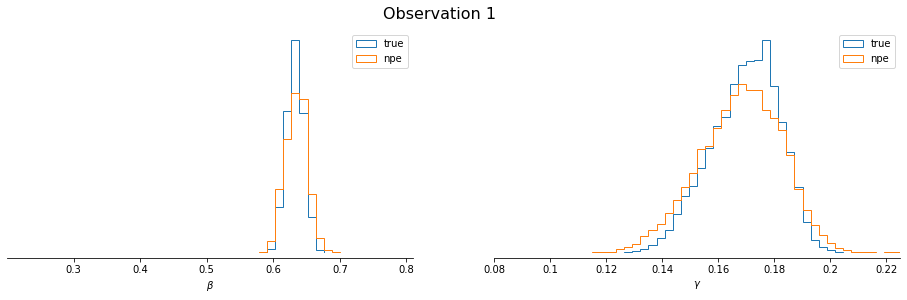

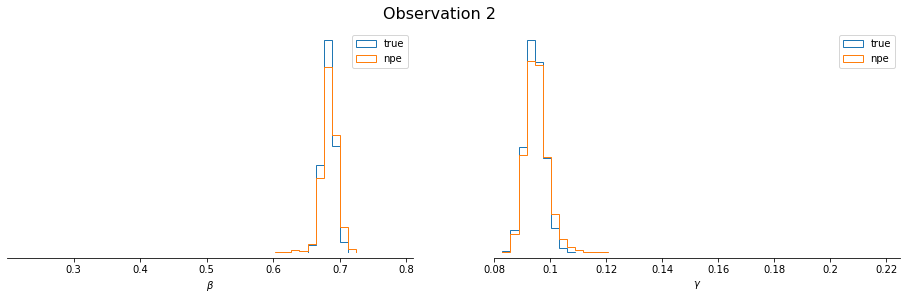

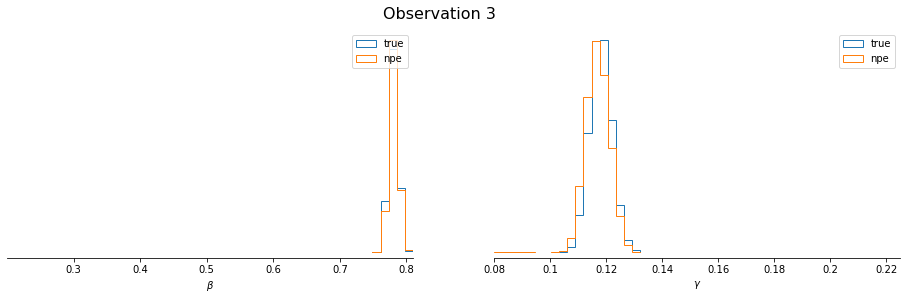

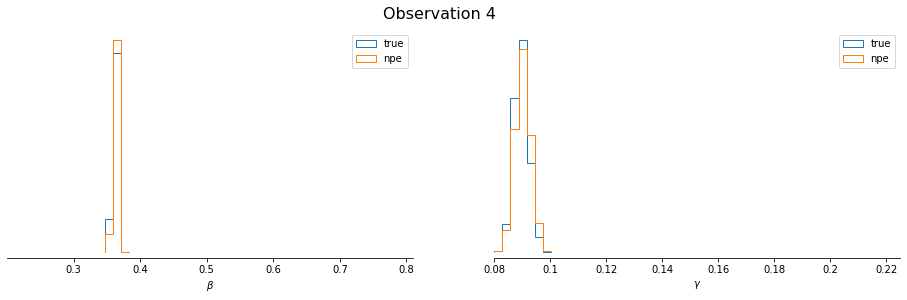

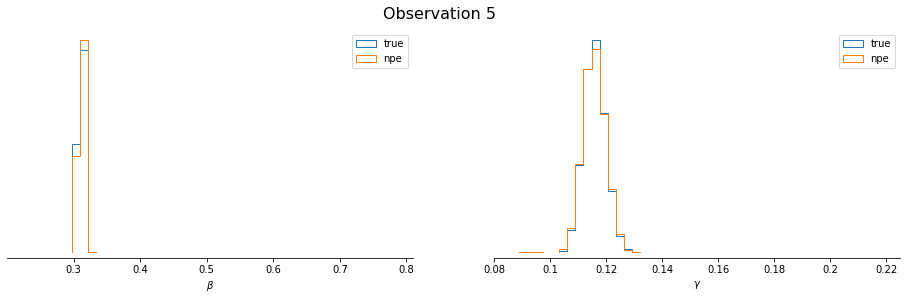

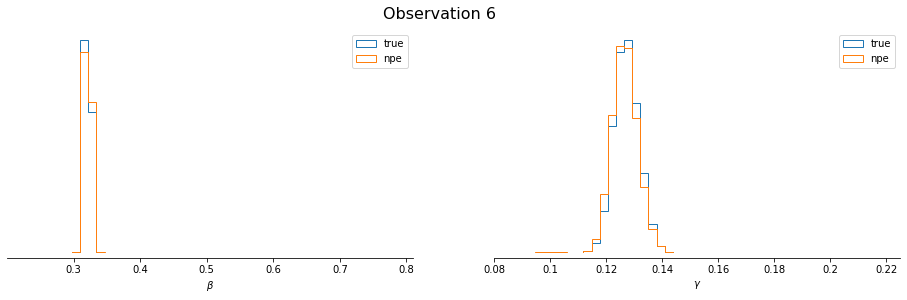

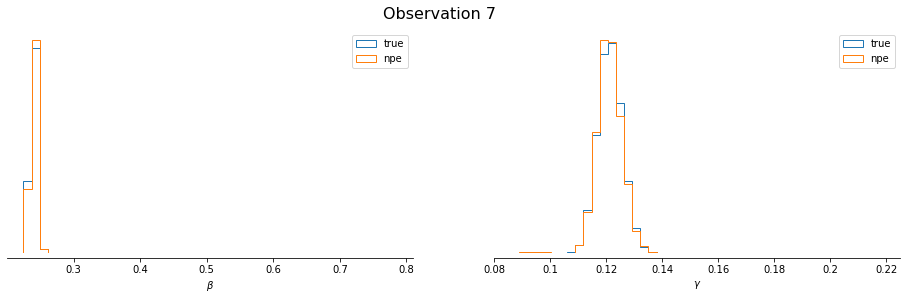

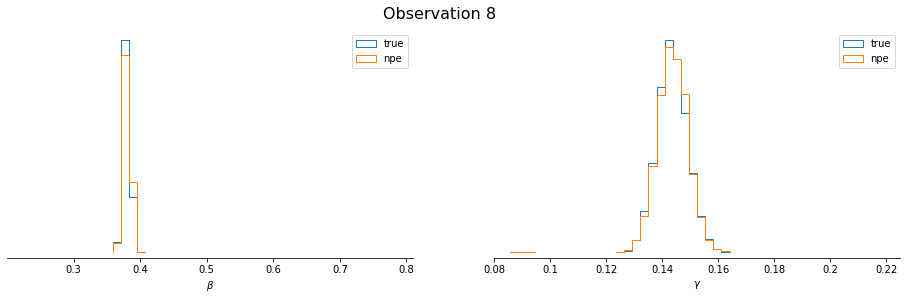

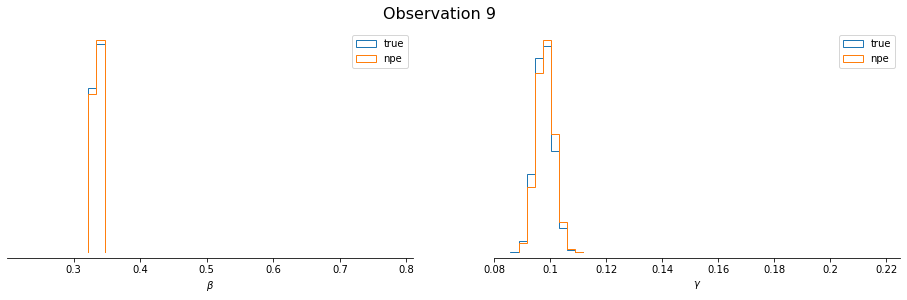

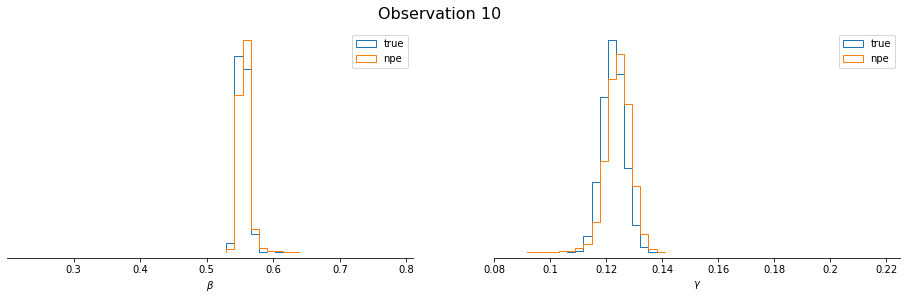

In [15]:
for obs in range(1,11):
    limits = [[0.2, 0.81], [0.08, 0.225]]
    marginal_plot([reference_samples[obs-1], npe_samples[obs-1]], limits=limits, figsize=(16,4), title=f'Observation {obs}', labels=[r'$\beta$', r'$\gamma$'], legend=True, labels_samples=['true', 'npe'])
    plt.savefig(f'./results/sir/marginal_plots/marginal_plot_obs{obs}.jpg')

## Classifier